# Analyse accuracy of Schroedinger-schemes

In [5]:
import config 
import numpy as np
import phase_schemes
import wave_schemes
import tests
import animation 
import analysis

import matplotlib.pyplot as plt 

from IPython.display import display, Markdown, Latex


def baseConfig():
    c = config.generateConfig(dt=1e-4, t0=0)
    c["dt"] = 1e-3
    c["domainSize"] = 1#2*np.pi
    c["resolution"] = 32
    c["timeOrder"] = 2
    c["dimension"] = 2
    c["tEnd"] = 2*np.pi/(0.5 * c["dimension"] * (2*np.pi/c["domainSize"])**2)
    #c["tEnd"] = 1/(2*np.pi*3*0.5) 
    ## For cosmo tests at L = 10, in general k = 2 pi / L, omega = 0.5/Eta * sum k_i^2 t = 2pi/omega
    c["stencilOrder"] = 4
    c["gravity"] = 0
    c["outputTimestep"] = False
    c["useAdaptiveTimestep"] = True
    c["fluxLimiter"] = "MINMOD"
    c["fps"] = 20
    c["slowDown"] = 20
    c["densityYlim"] = [0.8, 1.2]
    c["plotDensityLogarithm"] = False
    c["cfl"] = 0.1
    return c


In [2]:
def cosmoAccuracyTest1D(xx, dx, t):
    return tests.cosmological1D(xx, dx, t, Lx=1, N=2, eps=1e-1)

def cosmoAccuracyTest2D(xx, yy, dx, t):
    return tests.cosmological2D(xx, yy, dx, t, Lx=1, Ly=1, N=2, eps=1e-1)

In [17]:
c["dimension"] = 2
solver = phase_schemes.HOUpwindScheme(c, cosmoAccuracyTest2D)
solver.dimension

2

In [21]:
solver.ghostBoundarySize

0

Number of frames: 63, time per frame (ms) = 2.5 and frames per second 20
Create animation with configuration:  {'dimension': 2, 'resolution': 64, 'domainSize': 1, 'usePeriodicBC': True, 'ghostBoundarySize': 3, 't0': 0, 'tEnd': 0.15915494309189535, 'dt': 0.001, 'slowDown': 20, 'fps': 20, 'useAdaptiveTimestep': True, 'cfl': 0.1, 'maximumNumberOfTimesteps': 100000, 'timeOrder': 2, 'stencilOrder': 4, 'fluxLimiter': 'MINMOD', 'gravity': 0, 'useCosmology': False, 'externalPotential': None, 'debug': False, 'outputTimestep': False, 'useHybrid': False, 'useAdaptiveSubregions': False, 'subregions': [], 'windowUpdateFrequency': 100, 'WindowSize': 0.5, 'mode': 0, 'enoOrder': 1, 'rhoOrder': 1, 'modifiedPQN': 3, 'xlim': [0, 1], 'densityYlim': [0.8, 1.2], 'phaseYlim': [-3.14, 3.14], 'plotDensityLogarithm': False, 'plotPhaseMod2': True, 'dpi': 80, 'artificialDiffusion': 1, 'fluxMode': 0, 'SPeriodicBoundary': True, 'fluidMode': 0, 'integrationOrigin': [0, 0], 'useSlopeLimiting': False, 'maxSpeedC': 1.0

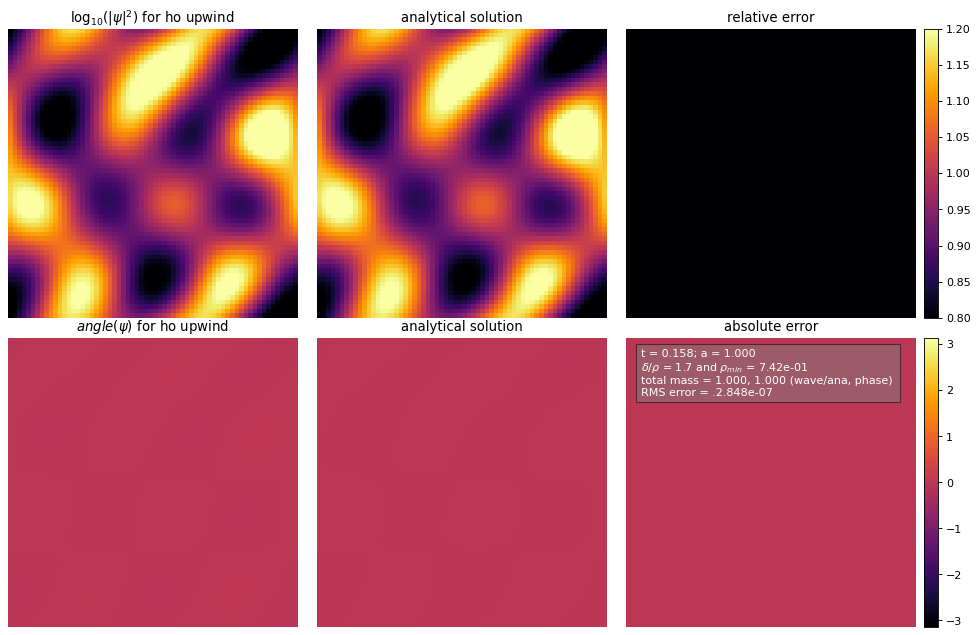

In [3]:
c = baseConfig()
c["resolution"] = 64
c["dimension"] = 2
c["xlim"] = [0, 1]
c["domainSize"] = 1
solver = phase_schemes.HOUpwindScheme(c, cosmoAccuracyTest2D)

animation.createAnimation(solver, "ho upwind", c, cosmoAccuracyTest2D, "houpwind_accuracy")

# 2D plots

## Test: cosmological initial condition without gravity

Mode spatial and temporal accuracy


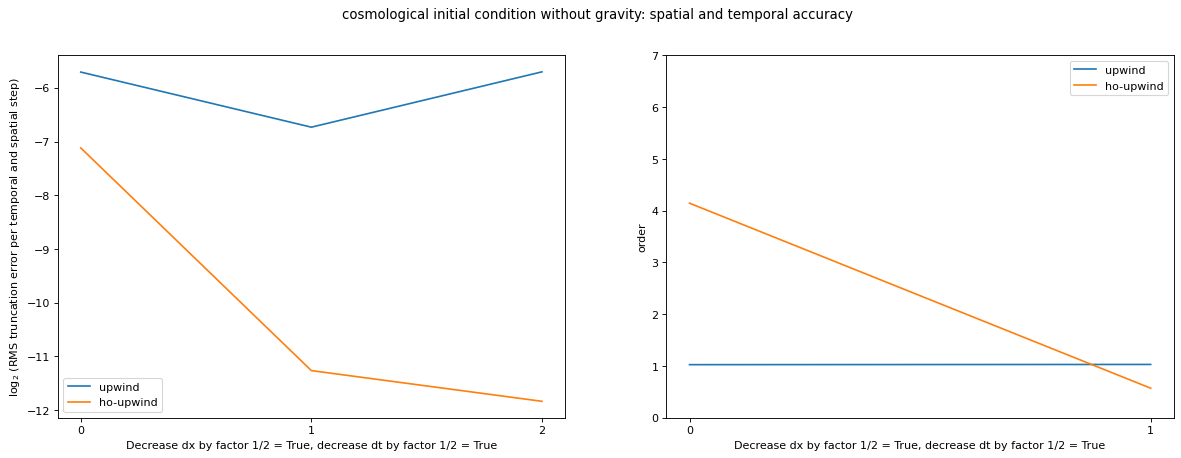

<Figure size 432x288 with 0 Axes>

In [7]:
N = 3
dimensions = [2]
tests_1d  = [cosmoAccuracyTest1D]
test_names_1d = ["cosmological initial condition without gravity"]
tests_2d  = [cosmoAccuracyTest2D]
test_names_2d = ["cosmological initial condition without gravity"]
tests_3d  = [tests.cosmological3D]
test_names_3d = ["cosmological initial condition without gravity"]

scheme_list = [phase_schemes.UpwindScheme, phase_schemes.HOUpwindScheme]#, schemes.CNScheme, schemes.MixedScheme, schemes.CDPhaseScheme]
scheme_names  = ["upwind", "ho-upwind"]#, "cranck-nicolson", "mixed", "cd-phase"]
mode_list = ["stencilOrder"]
mode_names = ["spatial and temporal accuracy"]

for dimension in dimensions:
    display(Markdown('#' + str(dimension) + "D plots"))
    
    def testConfig():
        c = baseConfig()
        c["dimension"] = dimension 
        return c 

    if dimension == 1:
        test_names = test_names_1d
        test_list      = tests_1d
    elif dimension == 2: 
        test_names = test_names_2d
        test_list      = tests_2d
    elif dimension == 3: 
        test_names = test_names_3d
        test_list      = tests_3d

    for test_name, test in zip(test_names, test_list):
        display(Markdown('##' + "Test: " + test_name))

        for mode_name, mode in zip(mode_names, mode_list):

            display(Markdown('##' + "Test: " + test_name))
            display(Markdown('###'  + "Mode: " + mode_name))

            truncations_errors = []
            labels = []


            halfDT = False 
            halfDX = False

            if mode_name == "spatial accuracy":
                halfDX = True
            elif mode_name == "temporal accuracy":
                halfDT = True
            else:
                halfDX = True 
                halfDT = True


            for scheme_name, scheme in zip(scheme_names, scheme_list):
                c = testConfig()
                p = analysis.analyseError(
                    scheme,
                    c,
                    test,
                    test,
                    N=N,
                    halfDT=halfDT,
                    halfDX=halfDX,
                    NT=10,
                    debug=False,
                    chopBoundary=False,
                    waveScheme=wave_schemes.SpectralScheme
                )

                truncations_errors.append(p)
                labels.append(scheme_name)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi = 80)
            plt.suptitle(test_name + ": " + mode_name)
            xx = np.arange(N)

            for i, p in enumerate(truncations_errors):
                ax1.plot(xx, np.log(p)/np.log(2), label=labels[i])
            ax1.legend()

            ax1.set_xlabel(
                f"Decrease dx by factor 1/2 = {halfDX}, decrease dt by factor 1/2 = {halfDT}"
            )

            ax1.set_ylabel(r"$\log_2$ (RMS truncation error per temporal and spatial step)")
            ax1.set_xticks(np.arange(N))
            ax1.set_xticklabels(np.arange(N))

            xx = np.arange(N - 1)

            ax2.set_xlabel(
                f"Decrease dx by factor 1/2 = {halfDX}, decrease dt by factor 1/2 = {halfDT}"
            )

            ax2.set_ylabel(r"order")
            ax2.set_xticks(np.arange(N))
            ax2.set_xticklabels(np.arange(N))
            ax2.set_yticks(np.arange(8))
            ax2.set_yticklabels(np.arange(8))
            ax2.set_ylim(0, 7)

            for i, p in enumerate(truncations_errors):
                error = np.log(p)/np.log(2)
                order = np.roll(error, -1) - error
                ax2.plot(xx, np.abs(order[:-1]), label=labels[i])
            ax2.legend()
            
            filename = str(dimension) + "d_" + mode_name + "_" + test_name
            plt.savefig("error_analysis/" + filename  + ".jpg")
            plt.show() 
            plt.clf()


In [ ]:
import analysis
import config
import numpy as np
import schemes
import tests
import convection_tests
import animation 

import matplotlib.pyplot as plt 

config = config.generateConfig(dt=1e-4, t0=0)


def resetConfig(config):
    config["dt"] = 1e-3
    config["domainSize"] = 1#2*np.pi
    config["resolution"] = 16
    config["timeOrder"] = 2
    config["tEnd"] = 1/(2*np.pi*3*0.5)
    #config["tEnd"] = 1/(2*np.pi*3*0.5) # For cosmo tests at L = 10, in general k = 2 pi / L, omega = 0.5/Eta * sum k_i^2 t = 2pi/omega
    config["stencilOrder"] = 2
    config["gravity"] = 0
    config["alpha"] = 2
    config["outputTimestep"] = False
    config["useAdaptiveTimestep"] = True

resetConfig(config)

if 0:
    solver = schemes.ConvectiveScheme(config, tests.periodicLi1)
    for i in range(10):
        solver.step(solver.dt)
    animation.drawFrame("li1_order_4_1", solver, tests.periodicLi1)


if 0:
    solver = schemes.ConvectiveScheme(config, tests.cosmological1D)
    for i in range(10):
        solver.step(solver.dt)
    animation.plotFields("cosmo_nograv_order_4_1", solver, tests.cosmological1D)


if 0:
    solver = schemes.ConvectiveScheme(config, tests.periodicLi3)
    for i in range(10):
        solver.step(solver.dt)
    animation.plotFields("li3_order_4_1", solver, tests.periodicLi3)

if 0:
    analysis.accuracyTest(
        "periodicLi1",
        schemes.ConvectiveScheme,
        config,
        tests.periodicLi1,
        tests.periodicLi1,
        resetConfig,
        N=5,
        halfDT=False,
        halfDX=True,
        NT=10,
        plotRef=True,
        debug=False,
        chopBoundary=False,
    )

if 0:
    analysis.accuracyTest(
        "periodicLi1_wave",
        schemes.WaveScheme,
        config,
        tests.periodicLi1,
        tests.periodicLi1,
        resetConfig,
        N=5,
        halfDT=False,
        halfDX=True,
        NT=10,
        plotRef=True,
        debug=False,
        chopBoundary=False,
    )

if 0:
    dimensions = [3]
    tests_1d  = [tests.cosmological1D, tests.periodicLi1, tests.periodicLi3]
    test_names_1d = ["cosmo", "li1", "li3"]
    tests_2d  = [tests.cosmological2D]
    test_names_2d = ["cosmo"]
    tests_3d  = [tests.cosmological3D]
    test_names_3d = ["cosmo"]

    schemes = [schemes.FourierScheme, schemes.ConvectiveScheme, schemes.UpwindScheme]
    scheme_names  = ["spectral", "convective", "phase"]
    mode = ["stencilOrder"]
    mode_names = ["space"]

    for dimension in dimensions:
        config["dimension"] = dimension
        if dimension == 1:
            test_names = test_names_1d
            tests      = tests_1d
        elif dimension == 2: 
            test_names = test_names_2d
            tests      = tests_2d
        elif dimension == 3: 
            test_names = test_names_3d
            tests      = tests_3d

        for test_name, test in zip(test_names, tests):
            for mode_name, mode in zip(mode_names, mode):
                for scheme_name, scheme in zip(scheme_names, schemes):
                    analysis.accuracyTest(
                        mode_name + "_" + test_name + "_" + scheme_name,
                        scheme,
                        config,
                        test,
                        test,
                        resetConfig,
                        N=5,
                        halfDT=False,
                        halfDX=True,
                        NT=10,
                        plotRef=True,
                        debug=False,
                        chopBoundary=False,
                        mode = mode
                    )

if 1:
    N = 3
    dimensions = [2]
    tests_1d  = [tests.cosmological1D]
    test_names_1d = ["cosmological initial condition without gravity"]
    tests_2d  = [tests.cosmological2D]
    test_names_2d = ["cosmological initial condition without gravity"]
    tests_3d  = [tests.cosmological3D]
    test_names_3d = ["cosmological initial condition without gravity"]

    schemes_ = [schemes.UpwindScheme, schemes.LaxWendroffUpwindScheme, schemes.HOUpwindScheme]#, schemes.CNScheme, schemes.MixedScheme, schemes.CDPhaseScheme]
    scheme_names  = ["convective", "upwind", "lax-wendroff", "ho-upwind"]#, "cranck-nicolson", "mixed", "cd-phase"]
    modes = ["stencilOrder"]
    mode_names = ["spatial and temporal accuracy"]

    for dimension in dimensions:
        print(f"\n\nMake {dimension}D plots")
        config["dimension"] = dimension
        if dimension == 1:
            test_names = test_names_1d
            tests      = tests_1d
        elif dimension == 2: 
            test_names = test_names_2d
            tests      = tests_2d
        elif dimension == 3: 
            test_names = test_names_3d
            tests      = tests_3d

        for test_name, test in zip(test_names, tests):
            print(f"\nRun test {test_name}")

            for mode_name, mode in zip(mode_names, modes):

                print(f"Mode {mode_name}")

                truncations_errors = []
                labels = []


                halfDT = False 
                halfDX = False

                if mode_name == "spatial accuracy":
                    halfDX = True
                elif mode_name == "temporal accuracy":
                    halfDT = True
                else:
                    halfDX = True 
                    halfDT = True


                for scheme_name, scheme in zip(scheme_names, schemes_):
                    resetConfig(config)
                    p = analysis.analyseError(
                        scheme,
                        config,
                        test,
                        test,
                        N=N,
                        halfDT=halfDT,
                        halfDX=halfDX,
                        NT=10,
                        debug=False,
                        chopBoundary=False#,
                        #waveScheme=schemes.FourierScheme
                    )

                    truncations_errors.append(p)
                    labels.append(scheme_name)

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi = 80)
                plt.suptitle(test_name + ": " + mode_name)
                xx = np.arange(N)

                for i, p in enumerate(truncations_errors):
                    ax1.plot(xx, np.log(p)/np.log(2), label=labels[i])
                ax1.legend()

                ax1.set_xlabel(
                    f"Decrease dx by factor 1/2 = {halfDX}, decrease dt by factor 1/2 = {halfDT}"
                )

                ax1.set_ylabel(r"$\log_2$ (RMS truncation error per temporal and spatial step)")
                ax1.set_xticks(np.arange(N))
                ax1.set_xticklabels(np.arange(N))

                xx = np.arange(N - 1)

                ax2.set_xlabel(
                    f"Decrease dx by factor 1/2 = {halfDX}, decrease dt by factor 1/2 = {halfDT}"
                )

                ax2.set_ylabel(r"order")
                ax2.set_xticks(np.arange(N))
                ax2.set_xticklabels(np.arange(N))
                ax2.set_yticks(np.arange(8))
                ax2.set_yticklabels(np.arange(8))
                ax2.set_ylim(0, 7)

                for i, p in enumerate(truncations_errors):
                    error = np.log(p)/np.log(2)
                    order = np.roll(error, -1) - error
                    ax2.plot(xx, np.abs(order[:-1]), label=labels[i])
                ax2.legend()
                
                filename = str(dimension) + "d_" + mode_name + "_" + test_name
                plt.savefig("error_analysis/" + filename  + ".jpg")
                plt.clf()
                plt.close()

if 0:
    analysis.accuracyTest(
        "cosmo_nograv",
        schemes.ConvectiveScheme,
        config,
        tests.cosmological2D,
        tests.cosmological2D,
        resetConfig,
        N=5,
        halfDT=False,
        halfDX=True,
        NT=10,
        plotRef=True,
        debug=False,
        chopBoundary=False,
    )

if 0:
    N = 3
    dimensions = [1, 2]
    tests_1d  = [convection_tests.periodicTest1D]
    test_names_1d = ["test 1"]
    tests_2d  = [convection_tests.periodicTest2D]
    test_names_2d = ["test 2"]

    schemes_ = [schemes.AdvectionScheme, schemes.HOAdvectionScheme, schemes.LaxWendroffScheme]
    scheme_names  = ["advection", "ho advection", "lax-wendroff"]
    modes = ["stencilOrder"]
    mode_names = ["spatial accuracy"]

    for dimension in dimensions:
        print(f"\n\nMake {dimension}D plots")
        config["dimension"] = dimension
        if dimension == 1:
            test_names = test_names_1d
            tests      = tests_1d
        elif dimension == 2: 
            test_names = test_names_2d
            tests      = tests_2d
        elif dimension == 3: 
            test_names = test_names_3d
            tests      = tests_3d

        for test_name, test in zip(test_names, tests):
            print(f"\nRun test {test_name}")

            for mode_name, mode in zip(mode_names, modes):

                print(f"Mode {mode_name}")

                truncations_errors = []
                labels = []


                halfDT = False 
                halfDX = False

                if mode_name == "spatial accuracy":
                    halfDX = True
                elif mode_name == "temporal accuracy":
                    halfDT = True
                else:
                    halfDX = True 
                    halfDT = True


                for scheme_name, scheme in zip(scheme_names, schemes_):
                    resetConfig(config)
                    p = analysis.analyseError(
                        scheme,
                        config,
                        test,
                        test,
                        N=N,
                        halfDT=halfDT,
                        halfDX=halfDX,
                        NT=10,
                        debug=False,
                        chopBoundary=False,
                        advection=True
                        #waveScheme=schemes.FourierScheme
                    )

                    truncations_errors.append(p)
                    labels.append(scheme_name)

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi = 80)
                plt.suptitle(test_name + ": " + mode_name)
                xx = np.arange(N)

                for i, p in enumerate(truncations_errors):
                    ax1.plot(xx, np.log(p)/np.log(2), label=labels[i])
                ax1.legend()

                ax1.set_xlabel(
                    f"Decrease dx by factor 1/2 = {halfDX}, decrease dt by factor 1/2 = {halfDT}"
                )

                ax1.set_ylabel(r"$\log_2$ (RMS truncation error per temporal and spatial step)")
                ax1.set_xticks(np.arange(N))
                ax1.set_xticklabels(np.arange(N))

                xx = np.arange(N - 1)

                ax2.set_xlabel(
                    f"Decrease dx by factor 1/2 = {halfDX}, decrease dt by factor 1/2 = {halfDT}"
                )

                ax2.set_ylabel(r"order")
                ax2.set_xticks(np.arange(N))
                ax2.set_xticklabels(np.arange(N))
                ax2.set_yticks(np.arange(8))
                ax2.set_yticklabels(np.arange(8))
                ax2.set_ylim(0, 7)

                for i, p in enumerate(truncations_errors):
                    error = np.log(p)/np.log(2)
                    order = np.roll(error, -1) - error
                    ax2.plot(xx, np.abs(order[:-1]), label=labels[i])
                ax2.legend()
                
                filename = str(dimension) + "d_" + mode_name + "_" + test_name
                plt.savefig("error_analysis/" + filename  + ".jpg")
                plt.clf()
                plt.close()